In [1]:
import pandas as pd
import numpy as np
import time
from keras.models import Sequential
from keras.layers import Dense,RepeatVector,Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('daily-website-visitors.csv')


In [3]:
data

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,2146,1582,1430,152
1,2,Monday,2,9/15/2014,3621,2528,2297,231
2,3,Tuesday,3,9/16/2014,3698,2630,2352,278
3,4,Wednesday,4,9/17/2014,3667,2614,2327,287
4,5,Thursday,5,9/18/2014,3316,2366,2130,236
...,...,...,...,...,...,...,...,...
2162,2163,Saturday,7,8/15/2020,2221,1696,1373,323
2163,2164,Sunday,1,8/16/2020,2724,2037,1686,351
2164,2165,Monday,2,8/17/2020,3456,2638,2181,457
2165,2166,Tuesday,3,8/18/2020,3581,2683,2184,499


In [4]:
data = data.filter(['Page.Loads'])


In [5]:
# Lấy 100 dòng cuối cùng của df
data = data.tail(1000)
data

,Page.Loads
1167,2658
1168,2391
1169,3202
1170,4349
1171,4886
...,...
2162,2221
2163,2724
2164,3456
2165,3581


In [6]:
#Tiền xử lý
data.fillna(0, inplace=True)

# Normalize data
scaler = MinMaxScaler()
dataScale = scaler.fit_transform(data.values.reshape(-1,1))

In [7]:
# Hàm tính giá trị alpha tối ưu
def optimum_alpha(X):
    X_max = np.max(X)
    X_min = np.min(X)
    n = len(X)
    return ((X_max - X_min) - (1/n) * np.sum(X)) / (X_max - X_min)


In [8]:
def smoothed(X, alpha):
    S = np.zeros_like(X)
    S[0] = X[0]
    for i in range(1, len(X)):
        S[i] = S[i-1] + alpha*(X[i] - S[i-1])
    return S

In [9]:
alpha = optimum_alpha(dataScale)


In [10]:
S = smoothed(dataScale, alpha)
print("Giá trị alpha tối ưu:", alpha)
print("Chuỗi ban đầu:", dataScale)
print("Chuỗi đã được làm mịn:", S)


Giá trị alpha tối ưu: 0.5528196155001501
Chuỗi ban đầu: [[0.20006008]
 [0.15995795]
 [0.2817663 ]
 [0.45404025]
 [0.5346951 ]
 [0.48498047]
 [0.47326524]
 [0.33808952]
 [0.16581556]
 [0.31886452]
 [0.54505858]
 [0.47296485]
 [0.49098828]
 [0.46936017]
 [0.31420847]
 [0.19209973]
 [0.32397116]
 [0.49939922]
 [0.40597777]
 [0.44397717]
 [0.42234905]
 [0.42114749]
 [0.18849504]
 [0.30474617]
 [0.47401622]
 [0.48933614]
 [0.41754281]
 [0.30820066]
 [0.16821868]
 [0.01817363]
 [0.        ]
 [0.04250526]
 [0.17347552]
 [0.22108741]
 [0.22273956]
 [0.13367378]
 [0.03304296]
 [0.00195254]
 [0.05752478]
 [0.30985281]
 [0.3101532 ]
 [0.35626314]
 [0.32817663]
 [0.14313608]
 [0.2246921 ]
 [0.43766897]
 [0.44953439]
 [0.43526585]
 [0.37113247]
 [0.27996395]
 [0.10093121]
 [0.17858216]
 [0.39411235]
 [0.40657855]
 [0.44202463]
 [0.42024632]
 [0.28567137]
 [0.14433764]
 [0.24331631]
 [0.49294082]
 [0.51967558]
 [0.51036347]
 [0.46425353]
 [0.3385401 ]
 [0.15304896]
 [0.27696005]
 [0.53109042]
 [0.49

D:\Download\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Download\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Smooth')

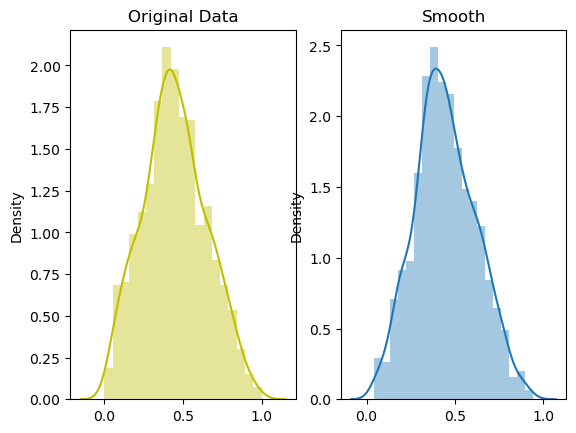

In [11]:
import seaborn as sns

fig, ax=plt.subplots(1,2)
sns.distplot(dataScale, ax=ax[0], color='y')
ax[0].set_title("Original Data")


sns.distplot(S,ax=ax[1])
ax[1].set_title("Smooth")


In [12]:
#Chia dữ liệu thành train test
data = pd.DataFrame(S)

#dataScale = data
train_percent = 0.7
train_size = int(len(data) * train_percent)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [13]:
#Chuẩn bị dữ liệu để đưa vào mô hình
def prepare_data(data, size_window,size_predict,stepWindow):
    X, y = [], []
    startWindow = 0
    for i in range(len(data) - size_window - 1):
        if (len(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0]) != size_predict):
            break
        X.append(data[startWindow:(startWindow + size_window), :])
        y.append(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])
          
       
        startWindow += stepWindow
    return np.array(X), np.array(y)


size_window = 7
size_predict = 1
stepWindow = 1
X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
X_test, y_test = prepare_data(test_data.values, size_window, size_predict, stepWindow)

In [14]:
start_time = time.time()

In [15]:

# Tạo mô hình CNN
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(size_window, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))

model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
for i in range(7):
    model.add(Dense(units=100, activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

# Compile mô hình với Adam optimizer và Mean Squared Error loss
model.compile(loss='mse', optimizer='adam')


In [16]:
history = model.fit(X_train, y_train, epochs=9000, batch_size=16)

Epoch 1/9000
44/44 [==============================] - 3s 2ms/step - loss: 0.1028
Epoch 2/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 3/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0251
Epoch 4/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 5/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 7/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 9/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 10/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 11/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 12/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 13/9000
44/44 [====

44/44 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 102/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 103/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 104/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 105/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 106/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 107/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 108/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 109/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 110/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 111/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 112/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 113/9000
44/4

44/44 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 298/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 299/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 300/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 301/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 302/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 303/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 304/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 305/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 306/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 307/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 308/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 309/9000
44/4

44/44 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 494/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 495/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 496/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 497/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 498/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 499/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 500/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 501/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 502/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 503/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 504/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 505/9000
44/4

44/44 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 690/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 691/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 692/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 693/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 694/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 695/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 696/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 697/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 698/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 699/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 700/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 701/9000
44/4

44/44 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 886/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 887/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 888/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 889/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 890/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 891/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 892/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 893/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 894/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 895/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 896/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 897/9000
44/4

44/44 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 1081/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 1082/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 1083/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1084/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1085/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1086/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1087/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 1088/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 1089/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1090/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1091/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 10

44/44 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 1275/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1276/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1277/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1278/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1279/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1280/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1281/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1282/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1283/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1284/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1285/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 12

44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1469/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1470/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 1471/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1472/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1473/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1474/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1475/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1476/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1477/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1478/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1479/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 14

44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1663/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1664/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1665/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1666/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1667/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1668/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 1669/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1670/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1671/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1672/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1673/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 16

44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1857/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1858/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1859/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1860/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1861/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1862/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 1863/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.9136e-04
Epoch 1864/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1865/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1866/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1867/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoc

44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2051/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 2052/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2053/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2054/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4000e-04
Epoch 2055/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2195e-04
Epoch 2056/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2057/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2058/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2059/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3445e-04
Epoch 2060/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 2061/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0

44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 2243/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 2244/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5996e-04
Epoch 2245/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2246/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.7296e-04
Epoch 2247/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2248/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2249/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 2250/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2251/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7874e-04
Epoch 2252/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.9719e-04
Epoch 2253/9000
44/44 [==============================] - 0s 2ms/step - loss:

44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2435/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 2436/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 2437/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2438/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 2439/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 2440/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 2441/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.9249e-04
Epoch 2442/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2443/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2444/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2445/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoc

44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2627/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2628/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2629/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2630/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7967e-04
Epoch 2631/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2632/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5388e-04
Epoch 2633/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5222e-04
Epoch 2634/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2635/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2636/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2637/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0

44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2723/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6086e-04
Epoch 2724/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 2725/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7205e-04
Epoch 2726/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 2727/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2728/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2729/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2466e-04
Epoch 2730/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 2731/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 2732/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.9170e-04
Epoch 2733/9000
44/44 [==============================] - 0s 2ms/step - loss:

44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2914/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2915/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2916/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2917/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.9697e-04
Epoch 2918/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2919/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2920/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7061e-04
Epoch 2921/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2922/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7568e-04
Epoch 2923/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8271e-04
Epoch 2924/9000
44/44 [==============================] - 0s 2ms/step - loss:

Epoch 3009/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 3010/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7036e-04
Epoch 3011/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2300e-04
Epoch 3012/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4840e-04
Epoch 3013/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.8217e-04
Epoch 3014/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 3015/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 3016/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 3017/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 3018/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3019/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6358e-04
Epoch 3020/9000
44/44 [==============================] -

44/44 [==============================] - 0s 2ms/step - loss: 8.6421e-04
Epoch 3200/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 3201/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 3202/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.9630e-04
Epoch 3203/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.8060e-04
Epoch 3204/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3205/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 3206/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3065e-04
Epoch 3207/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2945e-04
Epoch 3208/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4253e-04
Epoch 3209/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 3210/9000
44/44 [==============================] - 0s 2ms/step

44/44 [==============================] - 0s 2ms/step - loss: 9.0645e-04
Epoch 3390/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6747e-04
Epoch 3391/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 3392/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3393/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4886e-04
Epoch 3394/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.6979e-04
Epoch 3395/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0176e-04
Epoch 3396/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4265e-04
Epoch 3397/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6523e-04
Epoch 3398/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.8576e-04
Epoch 3399/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0424e-04
Epoch 3400/9000
44/44 [==============================] -

44/44 [==============================] - 0s 2ms/step - loss: 9.7184e-04
Epoch 3580/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1744e-04
Epoch 3581/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.8406e-04
Epoch 3582/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 3583/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 3584/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3585/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2216e-04
Epoch 3586/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7974e-04
Epoch 3587/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 3588/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3589/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3590/9000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 8.6333e-04
Epoch 3675/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 3676/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8119e-04
Epoch 3677/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3678/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5413e-04
Epoch 3679/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.9047e-04
Epoch 3680/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3681/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1404e-04
Epoch 3682/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3006e-04
Epoch 3683/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.4406e-04
Epoch 3684/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5924e-04
Epoch 3685/9000
44/44 [==============================] - 0s 

44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3865/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7478e-04
Epoch 3866/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5248e-04
Epoch 3867/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6144e-04
Epoch 3868/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2882e-04
Epoch 3869/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6684e-04
Epoch 3870/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0893e-04
Epoch 3871/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4829e-04
Epoch 3872/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 3873/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7670e-04
Epoch 3874/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3875/9000
44/44 [==============================] - 0s 

44/44 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 3960/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5245e-04
Epoch 3961/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2846e-04
Epoch 3962/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 3963/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3964/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.8201e-04
Epoch 3965/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5489e-04
Epoch 3966/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7756e-04
Epoch 3967/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4610e-04
Epoch 3968/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 3969/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7821e-04
Epoch 3970/9000
44/44 [==============================] - 0s 2ms/

44/44 [==============================] - 0s 2ms/step - loss: 9.2169e-04
Epoch 4148/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 4149/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 4150/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.9719e-04
Epoch 4151/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5462e-04
Epoch 4152/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3944e-04
Epoch 4153/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6517e-04
Epoch 4154/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 4155/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 4156/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.8940e-04
Epoch 4157/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5251e-04
Epoch 4158/9000
44/44 [==============================] - 0s 2ms/

44/44 [==============================] - 0s 2ms/step - loss: 8.7185e-04
Epoch 4337/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1881e-04
Epoch 4338/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 4339/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.7049e-04
Epoch 4340/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.9565e-04
Epoch 4341/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0207e-04
Epoch 4342/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.8312e-04
Epoch 4343/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 4344/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.8579e-04
Epoch 4345/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 4346/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.9027e-04
Epoch 4347/9000
44/44 [==============================] - 0s 

44/44 [==============================] - 0s 2ms/step - loss: 9.9271e-04
Epoch 4525/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 4526/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.4963e-04
Epoch 4527/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5522e-04
Epoch 4528/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1138e-04
Epoch 4529/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8230e-04
Epoch 4530/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2047e-04
Epoch 4531/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6042e-04
Epoch 4532/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 4533/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.3542e-04
Epoch 4534/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8766e-04
Epoch 4535/9000
44/44 [==============================] -

44/44 [==============================] - 0s 2ms/step - loss: 9.0003e-04
Epoch 4713/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.9587e-04
Epoch 4714/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3451e-04
Epoch 4715/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5600e-04
Epoch 4716/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6757e-04
Epoch 4717/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3796e-04
Epoch 4718/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 4719/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6126e-04
Epoch 4720/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 4721/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8328e-04
Epoch 4722/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.8886e-04
Epoch 4723/9000
44/44 [==============================] -

44/44 [==============================] - 0s 2ms/step - loss: 7.8639e-04
Epoch 4901/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3699e-04
Epoch 4902/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0118e-04
Epoch 4903/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.9491e-04
Epoch 4904/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 4905/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5302e-04
Epoch 4906/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.9076e-04
Epoch 4907/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0998e-04
Epoch 4908/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6887e-04
Epoch 4909/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0446e-04
Epoch 4910/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.4288e-04
Epoch 4911/9000
44/44 [=============================

44/44 [==============================] - 0s 2ms/step - loss: 9.6609e-04
Epoch 5089/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3837e-04
Epoch 5090/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 5091/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1683e-04
Epoch 5092/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 5093/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5769e-04
Epoch 5094/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 5095/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4890e-04
Epoch 5096/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5144e-04
Epoch 5097/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6992e-04
Epoch 5098/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.9409e-04
Epoch 5099/9000
44/44 [==============================] - 0s 

44/44 [==============================] - 0s 2ms/step - loss: 8.2579e-04
Epoch 5277/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5779e-04
Epoch 5278/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 5279/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5163e-04
Epoch 5280/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1274e-04
Epoch 5281/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7617e-04
Epoch 5282/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8800e-04
Epoch 5283/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 5284/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 5285/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 5286/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 5287/9000
44/44 [==============================] - 0s 2ms/step

44/44 [==============================] - 0s 2ms/step - loss: 9.4608e-04
Epoch 5465/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3348e-04
Epoch 5466/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7406e-04
Epoch 5467/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3018e-04
Epoch 5468/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.4572e-04
Epoch 5469/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6742e-04
Epoch 5470/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3166e-04
Epoch 5471/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6094e-04
Epoch 5472/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 5473/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8922e-04
Epoch 5474/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5111e-04
Epoch 5475/9000
44/44 [=============================

44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 5559/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1752e-04
Epoch 5560/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.9235e-04
Epoch 5561/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5415e-04
Epoch 5562/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8977e-04
Epoch 5563/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 5564/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.9373e-04
Epoch 5565/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 5566/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7323e-04
Epoch 5567/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.2109e-04
Epoch 5568/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0009e-04
Epoch 5569/9000
44/44 [==============================] - 0s 

Epoch 5652/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 5653/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 5654/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 5655/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5278e-04
Epoch 5656/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0218e-04
Epoch 5657/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 5658/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3846e-04
Epoch 5659/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.7645e-04
Epoch 5660/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7017e-04
Epoch 5661/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.6863e-04
Epoch 5662/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.9620e-04
Epoch 5663/9000
44/44 [=========================

44/44 [==============================] - 0s 2ms/step - loss: 9.3609e-04
Epoch 5747/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5922e-04
Epoch 5748/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8070e-04
Epoch 5749/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8797e-04
Epoch 5750/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 5751/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0664e-04
Epoch 5752/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.7375e-04
Epoch 5753/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3657e-04
Epoch 5754/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.2531e-04
Epoch 5755/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4684e-04
Epoch 5756/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.8175e-04
Epoch 5757/9000
44/44 [=============================

44/44 [==============================] - 0s 2ms/step - loss: 9.2704e-04
Epoch 5935/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.0677e-04
Epoch 5936/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 5937/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 5938/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.9495e-04
Epoch 5939/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.4321e-04
Epoch 5940/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5485e-04
Epoch 5941/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 5942/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 5943/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6747e-04
Epoch 5944/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7847e-04
Epoch 5945/9000
44/44 [==============================] - 0s 2ms/

44/44 [==============================] - 0s 2ms/step - loss: 9.9811e-04
Epoch 6123/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2399e-04
Epoch 6124/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.4271e-04
Epoch 6125/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.2093e-04
Epoch 6126/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2076e-04
Epoch 6127/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.8755e-04
Epoch 6128/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5549e-04
Epoch 6129/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 6130/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.2368e-04
Epoch 6131/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8172e-04
Epoch 6132/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.0429e-04
Epoch 6133/9000
44/44 [=============================

44/44 [==============================] - 0s 2ms/step - loss: 8.2627e-04
Epoch 6310/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.9041e-04
Epoch 6311/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8531e-04
Epoch 6312/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2514e-04
Epoch 6313/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5793e-04
Epoch 6314/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 6315/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6316/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6897e-04
Epoch 6317/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6318/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6319/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6320/9000
44/44 [==============================] - 0s 2ms/step

44/44 [==============================] - 0s 2ms/step - loss: 8.8616e-04
Epoch 6498/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.7151e-04
Epoch 6499/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4664e-04
Epoch 6500/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 6501/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 6502/9000
44/44 [==============================] - 0s 2ms/step - loss: 6.9697e-04
Epoch 6503/9000
44/44 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 6504/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0148e-04
Epoch 6505/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3025e-04
Epoch 6506/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2476e-04
Epoch 6507/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6508/9000
44/44 [==============================] - 0s 2ms/

44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6592/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0613e-04
Epoch 6593/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6594/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 6595/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4594e-04
Epoch 6596/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1818e-04
Epoch 6597/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.0330e-04
Epoch 6598/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.7161e-04
Epoch 6599/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4021e-04
Epoch 6600/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6601/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5372e-04
Epoch 6602/9000
44/44 [==============================] - 0s 2ms/

44/44 [==============================] - 0s 2ms/step - loss: 9.2892e-04
Epoch 6779/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 6780/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1993e-04
Epoch 6781/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4769e-04
Epoch 6782/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2355e-04
Epoch 6783/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.9219e-04
Epoch 6784/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5254e-04
Epoch 6785/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.6772e-04
Epoch 6786/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.3871e-04
Epoch 6787/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.2025e-04
Epoch 6788/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 6789/9000
44/44 [==============================] -

44/44 [==============================] - 0s 2ms/step - loss: 8.3639e-04
Epoch 6966/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5475e-04
Epoch 6967/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.0098e-04
Epoch 6968/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6969/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 6970/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 6971/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6972/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6973/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.9948e-04
Epoch 6974/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.9443e-04
Epoch 6975/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.4928e-04
Epoch 6976/9000
44/44 [==============================] - 0s 2ms/step

44/44 [==============================] - 0s 2ms/step - loss: 8.7196e-04
Epoch 7153/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7154/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1557e-04
Epoch 7155/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.4956e-04
Epoch 7156/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.2638e-04
Epoch 7157/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.4833e-04
Epoch 7158/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.4500e-04
Epoch 7159/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.6664e-04
Epoch 7160/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8127e-04
Epoch 7161/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.9124e-04
Epoch 7162/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4108e-04
Epoch 7163/9000
44/44 [=============================

44/44 [==============================] - 0s 2ms/step - loss: 8.8089e-04
Epoch 7340/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8053e-04
Epoch 7341/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.3541e-04
Epoch 7342/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.0216e-04
Epoch 7343/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.0289e-04
Epoch 7344/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.4276e-04
Epoch 7345/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1487e-04
Epoch 7346/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.6860e-04
Epoch 7347/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.8432e-04
Epoch 7348/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.3734e-04
Epoch 7349/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.3731e-04
Epoch 7350/9000
44/44 [=========================

44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 7526/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2730e-04
Epoch 7527/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 7528/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1043e-04
Epoch 7529/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1091e-04
Epoch 7530/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.2371e-04
Epoch 7531/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 7532/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7533/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7534/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7257e-04
Epoch 7535/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.5105e-04
Epoch 7536/9000
44/44 [==============================] - 0s 2ms/step

44/44 [==============================] - 0s 2ms/step - loss: 8.8848e-04
Epoch 7620/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 7621/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.8828e-04
Epoch 7622/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 7623/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7624/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7625/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.7877e-04
Epoch 7626/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7627/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7628/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1902e-04
Epoch 7629/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8778e-04
Epoch 7630/9000
44/44 [==============================] - 0s 2ms/step - l

44/44 [==============================] - 0s 2ms/step - loss: 9.7059e-04
Epoch 7714/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6330e-04
Epoch 7715/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7716/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5880e-04
Epoch 7717/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.0816e-04
Epoch 7718/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7719/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0600e-04
Epoch 7720/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0516e-04
Epoch 7721/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3407e-04
Epoch 7722/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7723/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4203e-04
Epoch 7724/9000
44/44 [==============================] - 0s 

44/44 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 7808/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2428e-04
Epoch 7809/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.1235e-04
Epoch 7810/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6279e-04
Epoch 7811/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0267e-04
Epoch 7812/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.8407e-04
Epoch 7813/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0519e-04
Epoch 7814/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5446e-04
Epoch 7815/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7632e-04
Epoch 7816/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.3153e-04
Epoch 7817/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 7818/9000
44/44 [==============================] -

Epoch 7901/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.9620e-04
Epoch 7902/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.1774e-04
Epoch 7903/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.7160e-04
Epoch 7904/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.8125e-04
Epoch 7905/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.3525e-04
Epoch 7906/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.3528e-04
Epoch 7907/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 7908/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.3611e-04
Epoch 7909/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0070e-04
Epoch 7910/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.2875e-04
Epoch 7911/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.5586e-04
Epoch 7912/9000
44/44 [=============

Epoch 8088/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4199e-04
Epoch 8089/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0366e-04
Epoch 8090/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4534e-04
Epoch 8091/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.3434e-04
Epoch 8092/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8967e-04
Epoch 8093/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3170e-04
Epoch 8094/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 8095/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 8096/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.3078e-04
Epoch 8097/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.7526e-04
Epoch 8098/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2831e-04
Epoch 8099/9000
44/44 [=================

44/44 [==============================] - 0s 2ms/step - loss: 7.9011e-04
Epoch 8275/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0499e-04
Epoch 8276/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.4805e-04
Epoch 8277/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.9392e-04
Epoch 8278/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5666e-04
Epoch 8279/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.0932e-04
Epoch 8280/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.7261e-04
Epoch 8281/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7909e-04
Epoch 8282/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0692e-04
Epoch 8283/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.6679e-04
Epoch 8284/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2209e-04
Epoch 8285/9000
44/44 [=========================

44/44 [==============================] - 0s 2ms/step - loss: 9.1338e-04
Epoch 8461/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.6135e-04
Epoch 8462/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0407e-04
Epoch 8463/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0699e-04
Epoch 8464/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.7821e-04
Epoch 8465/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1078e-04
Epoch 8466/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.1031e-04
Epoch 8467/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5103e-04
Epoch 8468/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.4971e-04
Epoch 8469/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8715e-04
Epoch 8470/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.2715e-04
Epoch 8471/9000
44/44 [=========================

44/44 [==============================] - 0s 2ms/step - loss: 9.5085e-04
Epoch 8647/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.7641e-04
Epoch 8648/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.3808e-04
Epoch 8649/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.4309e-04
Epoch 8650/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.4422e-04
Epoch 8651/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1115e-04
Epoch 8652/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.9617e-04
Epoch 8653/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.5424e-04
Epoch 8654/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.5392e-04
Epoch 8655/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.6158e-04
Epoch 8656/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8272e-04
Epoch 8657/9000
44/44 [=========================

44/44 [==============================] - 0s 2ms/step - loss: 7.8258e-04
Epoch 8833/9000
44/44 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 8834/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.7803e-04
Epoch 8835/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.2437e-04
Epoch 8836/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.1241e-04
Epoch 8837/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.0902e-04
Epoch 8838/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.8414e-04
Epoch 8839/9000
44/44 [==============================] - 0s 2ms/step - loss: 9.2202e-04
Epoch 8840/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.9935e-04
Epoch 8841/9000
44/44 [==============================] - 0s 2ms/step - loss: 7.8746e-04
Epoch 8842/9000
44/44 [==============================] - 0s 2ms/step - loss: 8.8212e-04
Epoch 8843/9000
44/44 [=============================

In [17]:
y_pred = model.predict(X_test)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

10/10 [==============================] - 0s 2ms/step
Training time: 777.2143380641937 seconds


In [18]:
import h5py

# Lưu mô hình CNN
model.save("Daily_SCNN_73.h5")

# Lưu các thông tin khác vào file H5
with h5py.File("Daily_SCNN_73_data.h5", "w") as file:
    file.create_dataset("y_test", data=y_test)
    file.create_dataset("X_test", data=X_test)
    file.create_dataset("training_time", data=training_time)
    file.create_dataset("alpha", data=alpha)
    file.create_dataset("S", data=S)
    file.create_dataset("dataScale", data =dataScale)
